In [87]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

class FeatureEngineering:
    def __init__(self, df):
        """Initializes the feature engineering class with the provided DataFrame."""
        self.df = df

    def handle_missing_data(self):
        """
        Handles missing data by imputing:
        - Numerical features: median
        - Categorical features: mode
        """
        numerical_features = self.df.select_dtypes(include=[np.number]).columns
        for feature in numerical_features:
            if self.df[feature].isnull().sum() > 0:
                self.df[feature].fillna(self.df[feature].median(), inplace=True)
        
        categorical_features = self.df.select_dtypes(include=[object]).columns
        for feature in categorical_features:
            if self.df[feature].isnull().sum() > 0:
                self.df[feature].fillna(self.df[feature].mode()[0], inplace=True)

    def add_total_area(self):
        """Adds a feature for the total area (Living_Area + Surface_area_plot_of_land)."""
        if 'Living_Area' in self.df.columns and 'Surface_area_plot_of_land' in self.df.columns:
            self.df['Total_Area'] = self.df['Living_Area'] + self.df['Surface_area_plot_of_land']

    def add_amenities_count(self):
        """Adds a feature that counts the total number of amenities."""
        amenities_columns = ['Fully_Equipped_Kitchen', 'Terrace', 'Garden', 'Swimming_Pool', 'Lift']
        if all(col in self.df.columns for col in amenities_columns):
            self.df['Total_Amenities'] = self.df[amenities_columns].sum(axis=1)

    def add_average_room_size(self):
        """Adds a feature for the average room size (Living_Area / Number_of_Rooms)."""
        if 'Living_Area' in self.df.columns and 'Number_of_Rooms' in self.df.columns:
            self.df['Average_Room_Size'] = np.where(self.df['Number_of_Rooms'] > 0, 
                                                     self.df['Living_Area'] / self.df['Number_of_Rooms'], 
                                                     0)


    def add_amenities_ratio(self):
        """Adds a ratio of amenities to the number of rooms."""
        if 'Number_of_Rooms' in self.df.columns and 'Total_Amenities' in self.df.columns:
            self.df['Amenities_Ratio'] = np.where(self.df['Number_of_Rooms'] > 0, 
                                                   self.df['Total_Amenities'] / self.df['Number_of_Rooms'], 
                                                   0)

    def apply_log_transformations(self):
        """
        Applies log transformations to skewed numerical features to reduce skewness.
        Currently applies to 'Living_Area', 'Total_Area', and 'total_income'.
        """
        numerical_features = ['Living_Area', 'Total_Area', 'total_income']
        for feature in numerical_features:
            if feature in self.df.columns:
                self.df[feature + '_log'] = np.log1p(self.df[feature])

    def add_clustered_regions(self, n_clusters=5):
        """
        Adds a clustered region feature based on Locality and Municipality.
        Uses KMeans clustering to assign regions.
        """
        if 'Locality' in self.df.columns and 'Municipality' in self.df.columns:
            combined_regions = self.df[['Locality', 'Municipality']].fillna('missing').astype(str)
            combined_regions_encoded = combined_regions.apply(lambda x: x.astype('category').cat.codes)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            self.df['Region_Cluster'] = kmeans.fit_predict(combined_regions_encoded)

    def add_interaction_features(self):
        """
        Adds interaction features for improved model performance.
        """
        if 'Distance_to_Nearest_Airport' in self.df.columns and 'Distance_to_Brussels' in self.df.columns:
            self.df['Airport_Brussels_Interaction'] = self.df['Distance_to_Nearest_Airport'] * self.df['Distance_to_Brussels']
        
        if 'Population Density' in self.df.columns and 'Unemployment Rate (%)' in self.df.columns:
            self.df['Density_Unemployment_Ratio'] = self.df['Population Density'] / (self.df['Unemployment Rate (%)'] + 1)
            
    def handle_outliers(self):
        """
        Caps outliers in numerical features to the 1st and 99th percentiles.
        """
        numerical_features = self.df.select_dtypes(include=[np.number]).columns
        for feature in numerical_features:
            lower_bound = self.df[feature].quantile(0.05)
            upper_bound = self.df[feature].quantile(0.95)
            self.df[feature] = np.clip(self.df[feature], lower_bound, upper_bound)
            

    def perform_feature_engineering(self):
        """
        Runs all feature engineering methods to enhance the dataset.
        Returns the transformed DataFrame.
        """
        self.handle_missing_data()          # Handle missing data first
        self.handle_outliers()              # Cap outliers
        self.add_total_area()               # Add total area
        self.add_amenities_count()          # Count total amenities
        self.add_average_room_size()        # Calculate average room size
        self.add_amenities_ratio()          # Compute amenities ratio
        self.apply_log_transformations()    # Log-transform skewed numerical features
        self.add_interaction_features()     # Add interaction features
        self.add_clustered_regions()        # Cluster regions
        return self.df                      # Return the transformed DataFrame


# Feature Engineering Usage Example
import pandas as pd

# Load the dataset
df = pd.read_csv("Data/immoweb_with_all_columns.csv")

# Apply feature engineering
feature_engineering = FeatureEngineering(df)

df_transformed = feature_engineering.perform_feature_engineering()

# Save the enhanced dataset
df_transformed.to_csv("Data/immoweb_features2.csv", index=False)


C:\Users\pc click\AppData\Local\Temp\ipykernel_25208\3974892798.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[feature].fillna(self.df[feature].median(), inplace=True)


In [92]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Step 2: Load the transformed dataset (Ensure your path is correct)
transformed_data_path = 'Data/immoweb_features2.csv'  # Ensure your path is correct
df_transformed = pd.read_csv(transformed_data_path)

# Step 3: Handle missing values and categorical features
categorical_features = [
    'Locality', 'Type_of_Property', 'Subtype_of_Property', 
    'State_of_the_Building', 'Fully_Equipped_Kitchen', 
    'Terrace', 'Garden', 'Swimming_Pool', 'Lift', 
    'Municipality', 'Province'
]

# Handle NaN values in categorical features
for col in categorical_features:
    df_transformed[col] = df_transformed[col].fillna('Unknown')
    df_transformed[col] = df_transformed[col].apply(lambda x: str(x) if isinstance(x, (float, int)) else x)

# Step 3: Handle outliers using Isolation Forest
numerical_features = df_transformed.select_dtypes(include=[np.number]).columns

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_transformed[numerical_features])

# Keep only the inliers (outliers = -1, inliers = 1)
df_transformed = df_transformed[outliers == 1]
# Step 4: Apply log transformation to the 'Price' column
df_transformed['Log_Price'] = np.log1p(df_transformed['Price'])  # log1p is log(1 + Price)

# Step 5: Prepare features and target variable
X = df_transformed.drop(columns=['Price', 'Log_Price'])  # Drop original and log-transformed 'Price' columns
y = df_transformed['Log_Price']  # Use the log-transformed price as the target variable

# Step 6: Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Use the best hyperparameters directly
best_params = {
    'learning_rate': 0.01,
    'iterations': 5000,
    'depth': 6,
    'border_count': 32,
    'bagging_temperature': 0.1,
    'l2_leaf_reg': 15
}

# Step 8: Initialize the CatBoostRegressor with the best parameters
best_model = CatBoostRegressor(
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    border_count=best_params['border_count'],
    bagging_temperature=best_params['bagging_temperature'],
    loss_function='RMSE', 
    cat_features=categorical_features,
    random_state=42,
    verbose=200,  # Adjust verbosity level
    early_stopping_rounds=50  # Early stopping to prevent unnecessary iterations
)

# Step 9: Train the model
best_model.fit(X_train, y_train)

# Step 10: Evaluate the model on the training and testing sets
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate the model's performance on the training and testing sets."""
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate RMSE for both training and test sets
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Print the RMSE
    print(f"Training RMSE: {train_rmse}")
    print(f"Test RMSE: {valid_rmse}")
    
    # Return RMSE for further analysis
    return train_rmse, valid_rmse

# Step 11: Evaluate the model
train_rmse, valid_rmse = evaluate_model(best_model, X_train, X_test, y_train, y_test)

# Step 12: Model performance metrics (MAE, R²)
def model_performance_metrics(model, X_test, y_test):
    """Print additional evaluation metrics like MAE and R²."""
    y_pred = model.predict(X_test)
    
    # Reverse the log transformation on predictions
    y_pred = np.expm1(y_pred)  # Inverse of log1p to get predicted 'Price'

    test_mae = mean_absolute_error(np.expm1(y_test), y_pred)  # Reverse log1p on y_test as well
    test_r2 = r2_score(np.expm1(y_test), y_pred)
    
    print(f"Test MAE: {test_mae}")
    print(f"Test R²: {test_r2}")

model_performance_metrics(best_model, X_test, y_test)



0:	learn: 0.4013205	total: 62.7ms	remaining: 5m 13s
200:	learn: 0.2575915	total: 15.6s	remaining: 6m 11s
400:	learn: 0.2304718	total: 30.9s	remaining: 5m 54s
600:	learn: 0.2204591	total: 45.4s	remaining: 5m 32s
800:	learn: 0.2147105	total: 59.7s	remaining: 5m 12s
1000:	learn: 0.2103366	total: 1m 15s	remaining: 5m
1200:	learn: 0.2069787	total: 1m 31s	remaining: 4m 48s
1400:	learn: 0.2047020	total: 1m 48s	remaining: 4m 37s
1600:	learn: 0.2029721	total: 2m 2s	remaining: 4m 20s
1800:	learn: 0.2012556	total: 2m 18s	remaining: 4m 5s
2000:	learn: 0.1996474	total: 2m 32s	remaining: 3m 48s
2200:	learn: 0.1980790	total: 2m 45s	remaining: 3m 30s
2400:	learn: 0.1966820	total: 2m 57s	remaining: 3m 12s
2600:	learn: 0.1954123	total: 3m 10s	remaining: 2m 55s
2800:	learn: 0.1942620	total: 3m 21s	remaining: 2m 38s
3000:	learn: 0.1932849	total: 3m 34s	remaining: 2m 22s
3200:	learn: 0.1923116	total: 3m 47s	remaining: 2m 7s
3400:	learn: 0.1913361	total: 4m 1s	remaining: 1m 53s
3600:	learn: 0.1904472	total:

Residuals Statistics:
Mean of residuals: 4367.324258241891
Standard deviation of residuals: 66361.29509550043
Max residual: 363595.27537573344
Min residual: -246333.91003348044


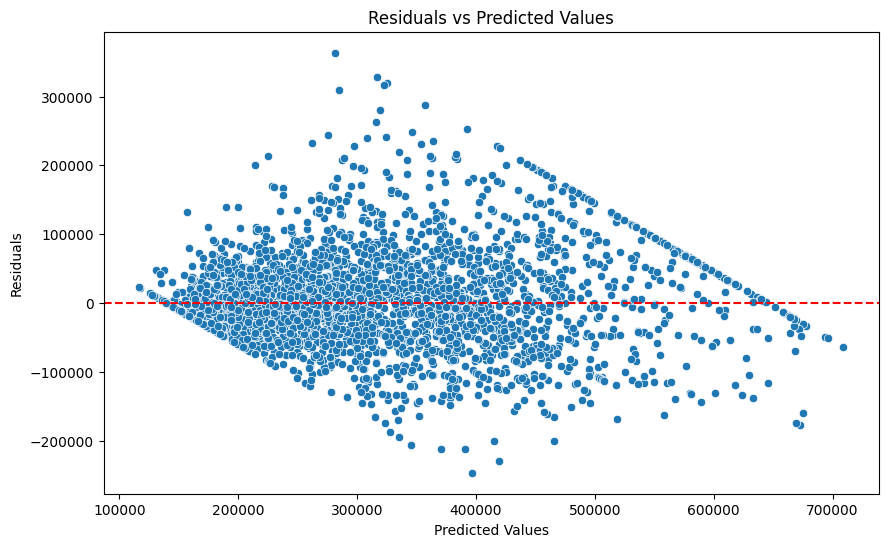

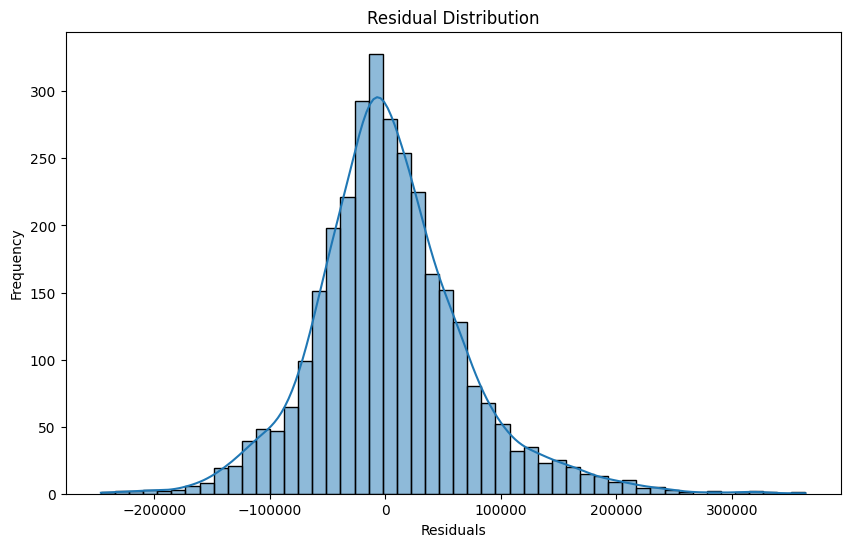


Feature Importance:
                         Feature  Importance
14                      Province   16.396010
5                    Living_Area   11.880378
25               Living_Area_log   11.461717
3          State_of_the_Building    9.738462
0                       Locality    8.657506
13                  Municipality    7.596091
28  Airport_Brussels_Interaction    3.678200
15          Distance_to_Brussels    3.235444
22               Total_Amenities    2.827484
2            Subtype_of_Property    2.696349
16   Distance_to_Nearest_Airport    2.603366
9      Surface_area_plot_of_land    2.454296
4                Number_of_Rooms    2.179877
21                    Total_Area    1.722673
26                Total_Area_log    1.582559
6         Fully_Equipped_Kitchen    1.307440
27              total_income_log    1.302122
12                          Lift    1.145992
23             Average_Room_Size    1.141048
17                  total_income    1.061487
10             Number_of_Facades  

C:\Users\pc click\AppData\Local\Temp\ipykernel_25208\1849475838.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


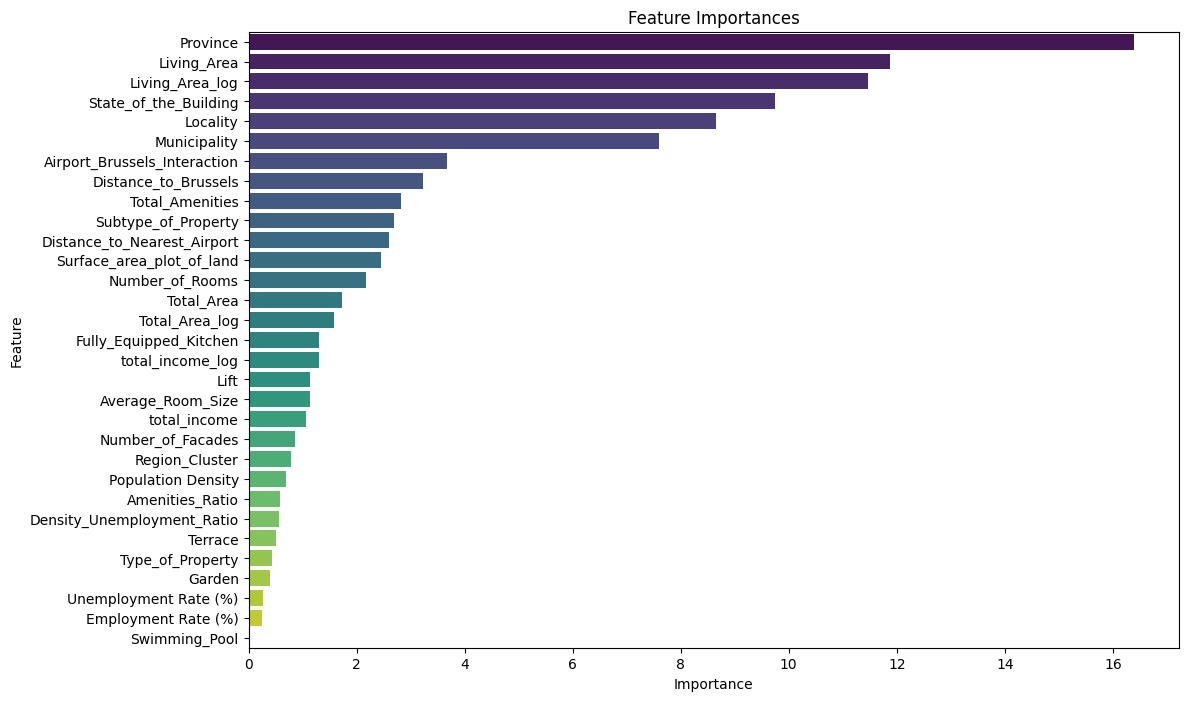

Model saved to catboost_model_with_tuning.cbm
Predictions saved to predictions.csv


In [93]:
# Step 13: Residuals analysis
def plot_residuals(model, X_test, y_test):
    """Plot residuals to evaluate the model's predictions."""
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)  # Inverse log transformation on predictions
    
    residuals = np.expm1(y_test) - y_pred  # Reverse log1p on y_test as well

    # Print residuals statistics
    print(f"Residuals Statistics:")
    print(f"Mean of residuals: {np.mean(residuals)}")
    print(f"Standard deviation of residuals: {np.std(residuals)}")
    print(f"Max residual: {np.max(residuals)}")
    print(f"Min residual: {np.min(residuals)}")
    
    # Plot residuals vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Values")
    plt.show()

    # Plot the distribution of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50)
    plt.title("Residual Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

# Plot residuals
plot_residuals(best_model, X_test, y_test)

# Step 14: Feature importance
def plot_feature_importance(model, feature_names):
    """Plot the feature importance to understand the model's decision-making process."""
    importances = model.get_feature_importance()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Print feature importance
    print("\nFeature Importance:")
    print(importance_df)
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title("Feature Importances")
    plt.show()

# Plot feature importance
plot_feature_importance(best_model, X_train.columns)

# Step 15: Save the model and predictions
model_path = 'catboost_model_with_tuning.cbm'
predictions_path = 'predictions.csv'

best_model.save_model(model_path)
np.savetxt(predictions_path, np.expm1(best_model.predict(X_test)), delimiter=",", header="Predicted Prices", comments="")

print(f"Model saved to {model_path}")
print(f"Predictions saved to {predictions_path}")


Generating SHAP summary plot...


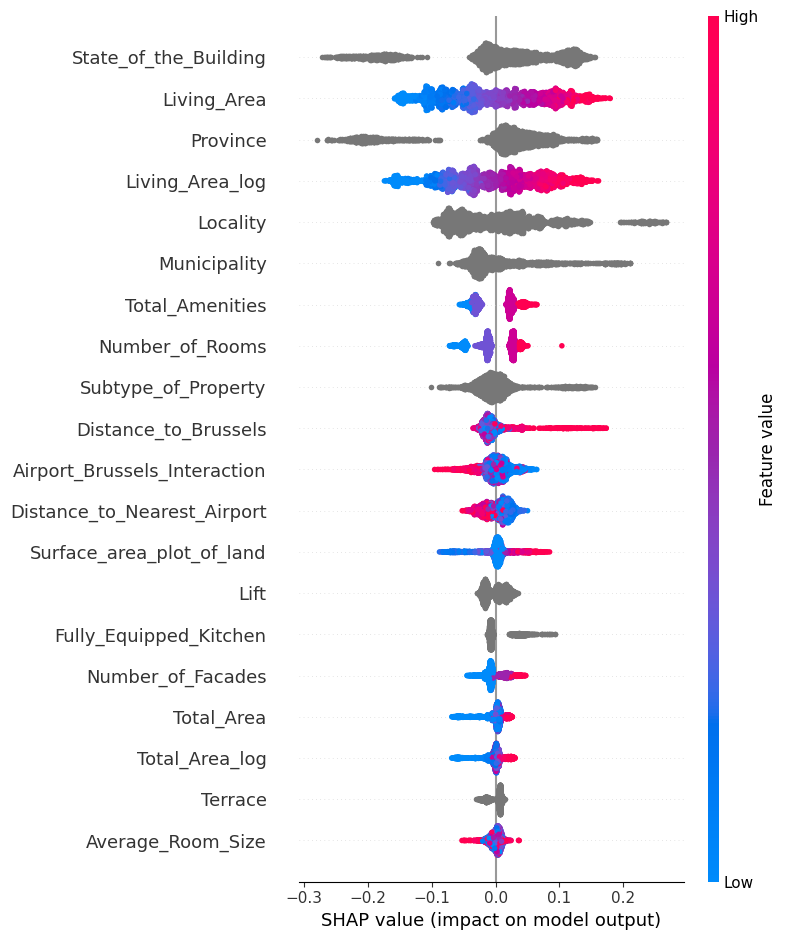

Generating SHAP bar plot...


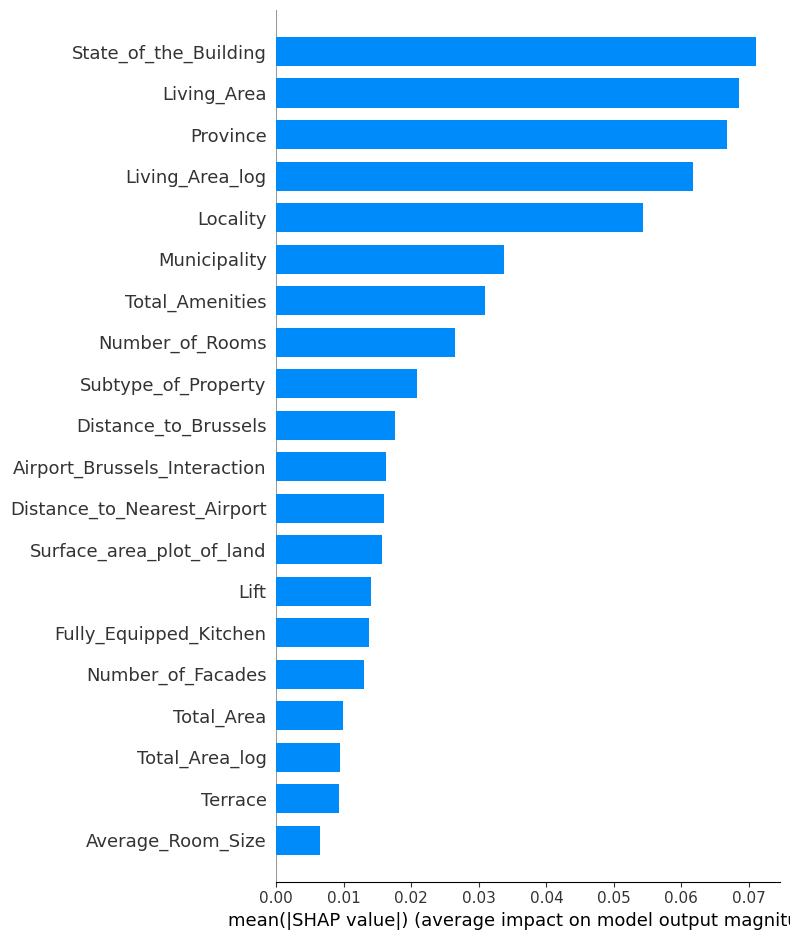

Visualizing a single prediction with SHAP...


In [96]:
import shap
# Initialize SHAP JavaScript visualizations
shap.initjs()
# SHAP Analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test)

# Plot feature importance bar plot
print("Generating SHAP bar plot...")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Visualize a single prediction
print("Visualizing a single prediction with SHAP...")
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])
